In [1]:
import pandas as pd
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
from scipy.stats import chisqprob
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
    return(x,y)   
    
n=1000 #int(input("how many steps?"))
alpha=2 #int(input("what's the scale?"))
beta=5 #int(input("what's the shape?"))
c=0.9# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
data = rw2(n)
x=data[0]
y=data[1]
t=range(0,n)

In [3]:
# my code pretty much starts here
time_step=0.2
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [4]:
x_new=f(t_new)
y_new=g(t_new)

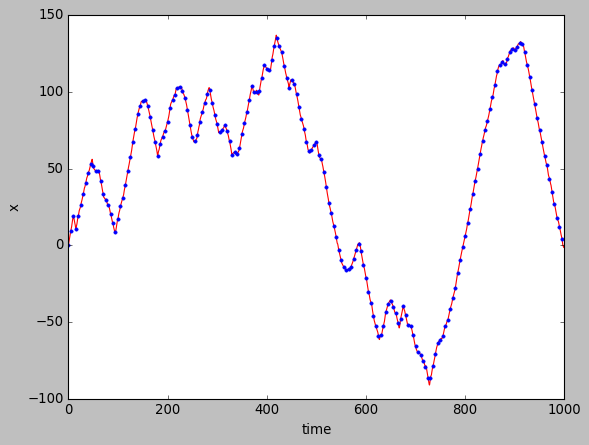

In [5]:
plt.plot(t_new,x_new,color='red')# got it
plt.plot(t[::5],x[::5],'.',color='blue')# blue dots
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [6]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

4994
4994
4994
4993
4993


In [7]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter

In [25]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.0035 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))



Acceptance rate = 0.424


0.968743159695
0.96874053476


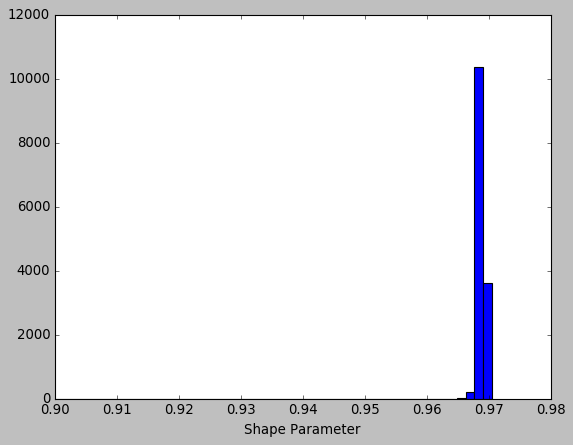

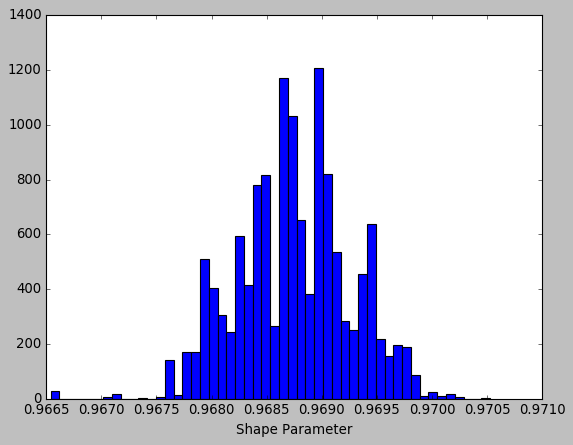

In [9]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()
B1=np.array(A1[1000:])
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()

In [10]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.0075,0.0075]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 10,000 iterations.
for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.4373


20001
4.40618715379
0.407182344914


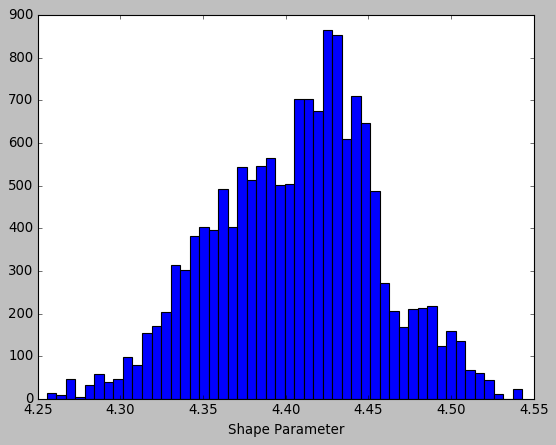

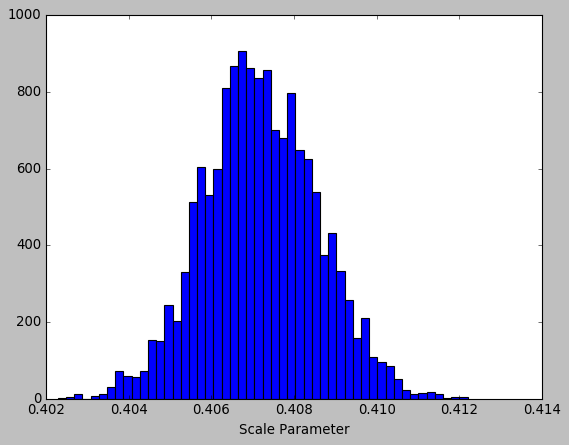

In [11]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 5000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [12]:
#Convergence here
def mh1(guess):
# Prepare storing MCMC chain as array of arrays.
    A1 = [guess]
    # define stepsize of MCMC.
    stepsizes = [0.0075,0.0075]  # array of stepsizes
    accepted  = 0.0
    old_theta=guess# define initial values for theta 
    old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 10,000 iterations.
    for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
        new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
        if new_theta[0]<0 or new_theta[1]<0: 
            continue
        new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
        if (new_loglik > old_loglik):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            u = random.uniform(0.0,1.0)
            if (u < math.exp(new_loglik - old_loglik)):
                A1.append(new_theta)
                accepted = accepted + 1.0  # monitor acceptance
                old_loglik=new_loglik
                old_theta=new_theta
            else:
                A1.append(old_theta)
    print("Acceptance rate = "+str(accepted/10000.0))
    return A1[1000:]

In [13]:
# Convergence for the step-lenghts parameters

sampless_shape = [mh1([theta,2]) for theta in np.linspace(2,7,5)]# 5 mh chains for shape keeping the scale fixed at 2 and varying 
# the starting points for the shape from 2 to 7
sampless_scale=[mh1([5,theta]) for theta in np.linspace(1,5,5)]
#5 mh chains for scale keeping the shape fixed at 5 and varying the starting points from 1 to 5

Acceptance rate = 0.4676
Acceptance rate = 0.4532
Acceptance rate = 0.4487
Acceptance rate = 0.4405
Acceptance rate = 0.4323
Acceptance rate = 0.418
Acceptance rate = 0.4366
Acceptance rate = 0.4607
Acceptance rate = 0.5089
Acceptance rate = 0.5188


In [14]:
final_shape_vector=[[p[0] for p in chain] for chain in sampless_shape]
final_scale_vector=[[p[1] for p in chain] for chain in sampless_scale]


Text(0.5,0,'Number of iterations')

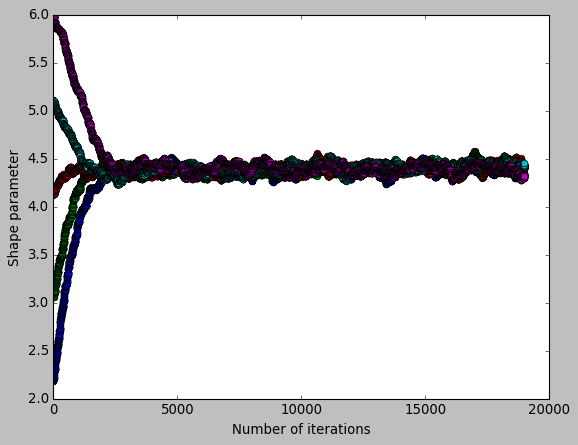

In [15]:
# Convergence of multiple chains for shape

for samples in final_shape_vector:
    plt.plot(samples, '-o')
plt.xlim([0, 20000])
#plt.ylim([0, 7])
plt.ylabel("Shape parameter")
plt.xlabel("Number of iterations")

Text(0.5,0,'Number of iterations')

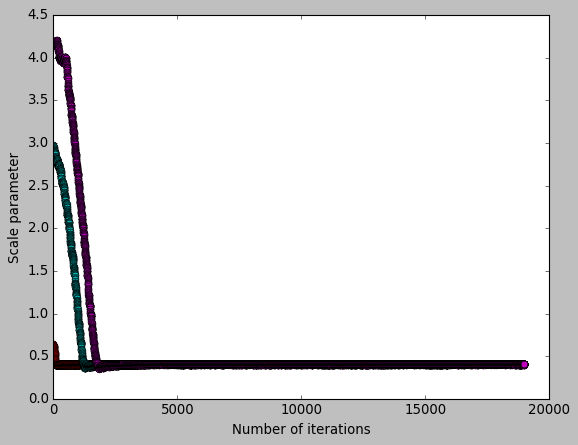

In [16]:
# Convergence of multiple chains for scale

for samples in final_scale_vector:
    plt.plot(samples, '-o')
plt.xlim([0, 20000])
#plt.ylim([0,6])
plt.ylabel("Scale parameter")
plt.xlabel("Number of iterations")

In [17]:
# x: data cell array
# m: no of chains run
# Within Chain Variance 
m=5
ssq_shape = np.zeros(m)
ssq_scale=np.zeros(m)
for j in range(0,m):
    ssq_shape[j]=np.var(final_shape_vector[j])
for j in range(0,m):
    ssq_scale[j]=np.var(final_scale_vector[j])    
    
Wvar_shape = np.mean(ssq_shape)
Wvar_scale=np.mean(ssq_scale)

In [18]:
# Between Chain Variance
schain_shape,schain_scale = 0,0
chainlng_shape=len(final_shape_vector[0])
chainlng_scale=len(final_scale_vector[0])
for j in range(0,m):
    schain_shape = schain_shape + np.mean(final_shape_vector[j]) # sum of all chain means
    schain_scale = schain_scale + np.mean(final_scale_vector[j])

mubar2_shape = (1/m)*schain_shape
mubar2_scale = (1/m)*schain_scale
bs_shape,bs_scale=0,0
for j in range(0,m):
    bs_shape=bs_shape+(np.mean(final_shape_vector[j])-mubar2_shape)**2
    bs_scale=bs_scale+(np.mean(final_scale_vector[j])-mubar2_scale)**2
Bvar_shape = (chainlng_shape/(m-1))*bs_shape # all chains have the same length
Bvar_scale = (chainlng_scale/(m-1))*bs_scale
# Estimated variance
muvar_shape = (1-1/chainlng_shape)*Wvar_shape + (1/chainlng_shape)*Bvar_shape
muvar_scale = (1-1/chainlng_scale)*Wvar_scale + (1/chainlng_scale)*Bvar_scale

# Potential Scale Reduction Factor
R_shape = np.sqrt(muvar_shape/Wvar_shape)
R_scale = np.sqrt(muvar_scale/Wvar_scale) 

print(R_shape)
print(R_scale)

1.05629506344
1.02820972918


In [26]:
# convergence for the heading

#guess = 0.9# initial guess for shape
def mh2(guess):
# Prepare storing MCMC chain as array of arrays.
    A2 = [guess]
    # define stepsize of MCMC.
    stepsizes = 0.0035 # array of stepsizes
    old_theta=guess# define initial values for theta 
    accepted  = 0.0
    old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
    old_logtarget=old_loglik
# Metropolis-Hastings with 10,000 iterations.
    for p in range(20000):
        new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
        #add the restraints on new_theta
        if new_theta<0:
            continue
        new_loglik = log_wclikelihood(new_data,new_theta,0)
        new_logtarget=new_loglik
    # Accept new candidate in Monte-Carlo fashing.
        if (new_logtarget > old_logtarget):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
            old_logtarget=new_logtarget
        else:
            u = random.uniform(0.0,1.0)
            if (u < math.exp(new_logtarget-old_logtarget)):
                A2.append(new_theta)
                accepted = accepted + 1.0  # monitor acceptance
                old_loglik=new_loglik
                old_theta=new_theta
                old_logtarget=new_logtarget 
            else:
                A2.append(old_theta)
    print("Acceptance rate = "+str(accepted/10000.0))
    return A2[1000:]

In [27]:
# convergence for the heading

nchains=5 #the number of chains
sampless_shapeh = [mh2(theta) for theta in np.linspace(0.5,0.99,nchains)]# 5 mh chains for shape keeping the scale fixed at 2 and varying 
# the starting points for the scale from 0.5 to 3               # should consider replacing 5 with a letter determining the number of chains

Acceptance rate = 0.4231
Acceptance rate = 0.435
Acceptance rate = 0.4182
Acceptance rate = 0.4221
Acceptance rate = 0.4119


In [28]:
# x: data cell array
# m: no of chains run
# Within Chain Variance 
m=nchains
ssq_shapeh=np.zeros(m)
for j in range(0,m):
    ssq_shapeh[j]=np.var(sampless_shapeh[j])    
Wvar_shapeh=np.mean(ssq_shapeh)

In [29]:
# Between Chain Variance
schain_shapeh=0
chainlng_shapeh=len(sampless_shapeh[0])
for j in range(0,m):
    schain_shapeh = schain_shapeh + np.mean(sampless_shapeh[j])
mubar2_shapeh = (1/m)*schain_shapeh
bs_shapeh=0
for j in range(0,m):
    bs_shapeh=bs_shapeh+(np.mean(sampless_shapeh[j])-mubar2_shapeh)**2
Bvar_shapeh = (chainlng_shapeh/(m-1))*bs_shapeh
# Estimated variance
muvar_shapeh = (1-1/chainlng_shapeh)*Wvar_shapeh + (1/chainlng_shapeh)*Bvar_shapeh

# Potential Scale Reduction Factor
R_shapeh = np.sqrt(muvar_shapeh/Wvar_shapeh) 

print(R_shapeh)# smaller than 1.1, so the chain has converged.

1.00013467979


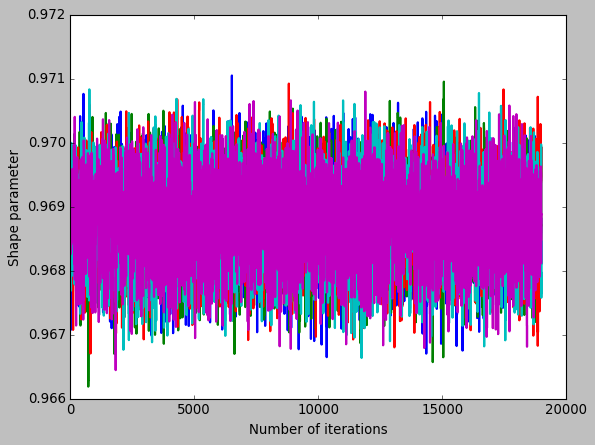

In [30]:
# Convergence of multiple chains for shape

for samples in sampless_shapeh:
    plt.plot(samples,lw=2)
plt.xlim([0, 20000])
#plt.ylim([0.5,1])
plt.ylabel("Shape parameter")
plt.xlabel("Number of iterations")
plt.show()

In [31]:
# now changing the parameters and n with the ones that I got
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    distance=[]
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance.append(r)# save the distances r for the mcmc sampler
    return [theta,distance]   
    
n=len(new_data) #int(input("how many steps?"))
alpha=scale_mean #int(input("what's the scale?"))
beta=shape_mean #int(input("what's the shape?"))
c=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
data = np.array(rw2(n)[1])
new_data=np.array(rw2(n)[0])


In [32]:
# graphs here, no more inference


In [33]:
#print(data)
#print(new_data)

In [34]:
#r=np.zeros(len(x_new)-1)# r the step-lengths
#theta=np.zeros(len(x_new)-1)# theta the angle
#new_data=np.zeros(len(x_new)-1)
#for i in range(0,len(x_new)-1):
 #   r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
  #  theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
#for i in range(0,len(x_new)-2):
 #   new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
  #  if new_data[i]<0:
   #     new_data[i]=new_data[i]+2*math.pi    
#data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
#print(len(data))    
#print(len(theta))
#print(len(new_data))
#new_data# it has a zero at the end
#new_data=new_data[:-1]
#new_data without zero.
#data=data[:-1]# change the step-lengths data as well
#print(len(data))
#print(len(new_data))# make sure they have the same lenghts

In [35]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
#guess = c
# Prepare storing MCMC chain as array of arrays.
#A1 = [guess]
# define stepsize of MCMC.
#stepsize = 0.08 # array of stepsizes
#accepted  = 0.0
#old_theta=guess# define initial values for theta 
#old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 10,000 iterations.
#for p in range(10000):
 #   new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
  #  if new_theta<0 or new_theta>1: 
   #     continue
    #new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    #if (new_loglik > old_loglik):
     #   A1.append(new_theta)
      #  accepted = accepted + 1.0  # monitor acceptance
       # old_loglik=new_loglik
        #old_theta=new_theta
    #else:
     #   u = random.uniform(0.0,1.0)
      #  if (u < math.exp(new_loglik - old_loglik)):
       #     A1.append(new_theta)
        #    accepted = accepted + 1.0  # monitor acceptance
         #   old_loglik=new_loglik
          #  old_theta=new_theta
        #else:
         #   A1.append(old_theta)
#print("Acceptance rate = "+str(accepted/10000.0))

In [36]:

#print(np.mean(A1))
#print(np.mean(A1[1000:]))# burn in 1000
#plt.hist(A1,bins=50)
#plt.xlabel("Shape Parameter")
#plt.show()
#B1=np.array(A1[1000:])
#plt.hist(B1,bins=50)
#plt.xlabel("Shape Parameter")
#plt.show()

In [37]:
# data has a zero at the beginning hence the error
#import scipy.stats as stats
#import numpy as np
# initial guess for theta(a and b) as array.
#guess = [beta,alpha]
# Prepare storing MCMC chain as array of arrays.
#A2 = [guess]
# define stepsize of MCMC.
#stepsizes = [0.013,0.013]  # array of stepsizes
#accepted  = 0.0
#old_theta=guess# define initial values for theta 
#old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 10,000 iterations.
#for p in range(10000):
    # Suggest new candidate from Gaussian proposal distribution.
 #   new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
  #  if new_theta[0]<0 or new_theta[1]<0: 
   #     continue
    #new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    #if (new_loglik > old_loglik):
     #   A2.append(new_theta)
      #  accepted = accepted + 1.0  # monitor acceptance
       # old_loglik=new_loglik
        #old_theta=new_theta
    #else:
     #   u = random.uniform(0.0,1.0)
      #  if (u < math.exp(new_loglik - old_loglik)):
       #     A2.append(new_theta)
        #    accepted = accepted + 1.0  # monitor acceptance
         #   old_loglik=new_loglik
          #  old_theta=new_theta
        #else:
         #   A2.append(old_theta)
#print("Acceptance rate = "+str(accepted/10000.0))

In [38]:
#print(len(A2))
#B2=np.array(A2[5000:])#burn-in 5000
#shape_mean=np.mean(B2[:,0])
#scale_mean=np.mean(B2[:,1])
#print(shape_mean)
#print(scale_mean)
#plt.hist(B2[:,0],bins=50)
#plt.xlabel("Shape Parameter")
#plt.show()
#plt.hist(B2[:,1],bins=50)
#plt.xlabel("Scale Parameter")
#plt.show()